# Total LeNet-5 compression compare

In [1]:
PATH_PREFIX = '../../'
import sys
sys.path.append(PATH_PREFIX)

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import os
import matplotlib.pyplot as plt

from data.mnist import MnistDataset
from data.utils.mnist_utils import *
from models.lenet.lenet import LeNet5
from utils.quantize import *
from utils.weight_sharing import *
from utils.plot import *

Setting parameters

In [3]:
# net settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100
NET_TYPE = 'relu'

# search settings
SEARCH_RANGE = range(1, 50)

NET_PATH =  os.path.join(PATH_PREFIX, f'models/lenet/saves/lenet_{NET_TYPE}.save')
SAVE_DATA = os.path.join(PATH_PREFIX, f'results/lenet_complete_share/complete_lenet_{NET_TYPE}_share.csv')

Initing model and dataset

In [4]:
dataset = MnistDataset(BATCH_SIZE, os.path.join(PATH_PREFIX, 'data'), val_split=0.5)
model = LeNet5(N_CLASSES, NET_TYPE)
criterion = nn.CrossEntropyLoss()

lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

optimizer = lam_opt(model)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

ws_controller = WeightShare(model, lam_test, lam_opt, lam_train)
ws_controller.set_reset()
ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Computing bedore compression loss

In [5]:
before_acc = lam_test()
before_acc

0.9846

Load or create the data

In [6]:
if os.path.isfile(SAVE_DATA):
    df = pd.read_csv(SAVE_DATA)
else:
    df = {
        'num_vals': [],
        'compression': [],
        'accuracy': []
    }

    # generating data
    for value in SEARCH_RANGE:
        perf = ws_controller.share_total(value)
        ws_controller.reset()
        df['num_vals'].append(value)
        df['compression'].append(perf['compression'])
        df['accuracy'].append(perf['accuracy'])

    df = pd.DataFrame(df)
    df['accuracy_loss'] = before_acc - df['accuracy']
    df.to_csv(SAVE_DATA)
df

,num_vals,compression,accuracy,accuracy_loss
0,1,31.997397,0.1002,0.8844
1,2,31.994795,0.3002,0.6844
2,3,15.997658,0.6216,0.3630
3,4,15.996877,0.8244,0.1602
4,5,10.664643,0.9602,0.0244
5,6,10.664238,0.9526,0.0320
6,7,10.663833,0.9764,0.0082
7,8,10.663428,0.9418,0.0428
8,9,7.997658,0.9654,0.0192
9,10,7.997398,0.9672,0.0174


Plotting results

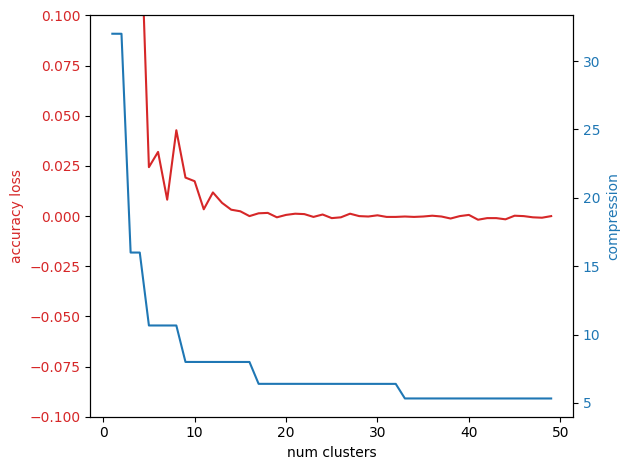

In [7]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('num clusters')
ax1.set_ylabel('accuracy loss', color=color)
ax1.plot(df['num_vals'], df['accuracy_loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim((-0.1, 0.1))

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('compression', color=color)
ax2.plot(df['num_vals'], df['compression'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Best compression above accuracy treshold

In [8]:
ACC_TRESHOLD = 0.01

df_f = df[df['accuracy_loss'] < ACC_TRESHOLD].sort_values('compression', ascending=False)
df_f.head()

,num_vals,compression,accuracy,accuracy_loss
6,7,10.663833,0.9764,0.0082
10,11,7.997138,0.9812,0.0034
12,13,7.996618,0.9780,0.0066
13,14,7.996358,0.9814,0.0032
14,15,7.996098,0.9822,0.0024


<AxesSubplot:xlabel='compression', ylabel='accuracy_loss'>

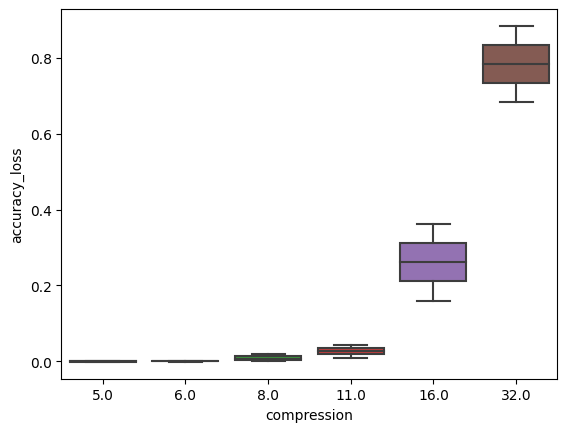

In [9]:
sns.boxplot(data=df.round({'compression': 0}), x='compression', y='accuracy_loss')